<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">About Dataset</h2>
    
<div style="background-color: #000000; text-align: justify; width: 600px; color: #ffffff; border-radius: 10px; padding: 10px;">
<span style="font-size: 20px; margin-bottom: 5px; color: blue; font-weight: bold;">Overview</span>
<p style="font-size: 16px; text-align: justify; padding: 10px; font-weight: normal; color: #ffffff;">
    The SMS Spam Collection is a dataset for SMS Spam research, featuring <code style="color: #ffffff;">5,574</code> English SMS messages tagged as "ham" (legitimate) or "spam."
    Each entry consists of two columns: 'v1' (label - ham/spam) and 'v2' (raw text). The dataset includes messages from various sources, such as the Grumbletext Web site, NUS SMS Corpus, Caroline Tag's PhD Thesis, and SMS Spam Corpus v.0.1 Big.
</p>
</div>

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Importing Packages</h2>

In [1]:
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
np.random.seed(20)

In [2]:
spam_df = pd.read_csv("spam.csv", encoding='latin-1', usecols=['v1', 'v2'])
spam_df.columns = ["label", "text"]
spam_df.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Helper Functions</h2>

<div style="background-color: #000000; text-align: justify; width: 600px; padding: 10px; border-radius: 10px;">
    <ul style="color: #ffffff; font-size: 16px; text-align: justify; padding: 25px; margin-top: 0;">
        <li>
            <strong style="color: #b09302;">plot_confusion_matrix:</strong>
            This function generates and visualizes a confusion matrix for the given model's predictions on the input data, including accuracy and normalized values.
        </li>
        <li>
            <strong style="color: #b09302;">build_model_pipeline:</strong>
            It creates a text classification pipeline using TF-IDF vectorization and the specified model, streamlining the model-building process.
        </li>
        <li>
            <strong style="color: #b09302;">plot_roc:</strong>
            This function plots the Receiver Operating Characteristic (ROC) curve for the model's predictions, providing insights into its performance and area under the curve (AUC) score.
        </li>
        <li>
            <strong style="color: #b09302;">evaluate_model:</strong>
            Given a model and input data, it evaluates and returns a DataFrame with precision, recall, and F1-score metrics for each class in the classification task, facilitating model assessment and comparison.
        </li>
    </ul>
</div>


In [3]:
def plot_confusion_matrix(model, X, y, ax, **kwargs):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)
    cm_norm = cm / cm.sum(1).reshape((-1, 1))
    labels = [f"{v}\n({pct:.2%})" for v, pct in zip(cm.flatten(), cm_norm.flatten())]
    labels = np.array(labels).reshape(cm.shape)

    sns.heatmap(cm, annot=labels, fmt="",
                ax=ax, yticklabels=le.classes_,
                xticklabels=le.classes_, cbar=False,
               cmap=["#1f1e1a", "#b09302"])
    ax.set_title(f"{kwargs.get('name').upper()} - {acc:.2%}", size=10.5, alpha=0.65)


def build_model_pipeline(model, name):
    pipeline = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(min_df=2, stop_words=list(ENGLISH_STOP_WORDS))),
        (name, model)
    ])
    return pipeline


def plot_roc(model, X, y, ax, **kwargs):
    pred_prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, pred_prob)
    fpr, tpr, threshold = roc_curve(y, pred_prob)

    ax.plot(fpr, tpr, label=f'{kwargs.get("name")} - AUC = {auc:.2%}')
    straight_line = np.linspace(0, 1, len(fpr))
    ax.plot(straight_line, straight_line)
    ax.fill_between(fpr, fpr, tpr, alpha=0.1)
    ax.legend(loc=4, frameon=True, edgecolor="gray")
    ax.set_title("ROC Curve", size=11)
    ax.grid(visible=False, axis="y")
    ax.set(ylabel="tpr", xlabel="fpr")


def evaluate_model(model, X, y, name):
    pred = model.predict(X)
    prf = precision_recall_fscore_support(y, pred)[:-1]
    metrics = "precision_recall_fscore".split("_")
    arrays = [["", name, ""], metrics]
    index = pd.MultiIndex.from_arrays(arrays, names=('model', 'metric'))
    df = pd.DataFrame(prf, columns=le.classes_, index=index)

    return df

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">EDA</h2>

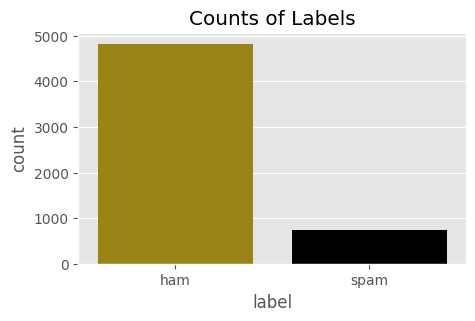

In [4]:
fig = plt.figure(figsize=(5, 3))
sns.countplot(data=spam_df, x='label', palette=["#b09302", "#000000"])
plt.title("Counts of Labels")
plt.show()

<p style="background-color: #000000; width: 620px; color: #ffffff; font-size: 16px; text-align: justify; padding: 20px; margin-top: 0px">
    The data is highly imbalanced. I downsampled the majority class so that they all have the same number of examples. <br><br>
<em>You can try <a href="https://www.kaggle.com/general/262007">upsampling.</a></em>
<p/>

In [5]:
spam = spam_df[spam_df.label=='spam']
ham = spam_df[spam_df.label=='ham'].sample(spam.shape[0])

spam_df = pd.concat([spam, ham], axis=0)

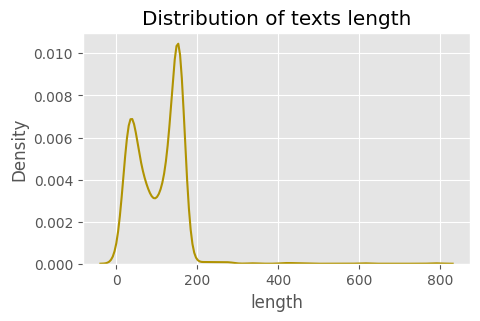

In [6]:
spam_df['length'] = spam_df.text.apply(len)

fig = plt.figure(figsize=(5, 3))
sns.kdeplot(data=spam_df, x='length', color = '#b09302')
plt.title("Distribution of texts length")
plt.show()

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Preprocessing Text</h2>

In [7]:
def process_text(message):
    text_split = message.lower().split()
    texts = [word for word in text_split if word not in string.punctuation]
    texts = [re.sub("[^a-zA-Z]", " ", word).strip() for word in texts]
    texts = " ".join(texts)
    texts = [word for word in texts.split() if word not in ENGLISH_STOP_WORDS and len(word)>1]

    return " ".join(texts)

In [8]:
process_text("Todays Voda numbers ending 1225 are selected to receive a å£50award. \
            If you have a match please call 08712300220 quoting claim code 3100 standard rates app")

'todays voda numbers ending selected receive award match quoting claim code standard rates app'

In [9]:
spam_df['text'] = spam_df['text'].apply(process_text)

spam_df.sample(5)

,label,text,length
1463,ham,ok good later come lucky told earlier later pp...,114
2313,ham,guys,23
3290,ham,smoking people use wylie smokes justify ruinin...,85
2604,ham,times job today ok umma ask speed,57
4018,spam,ve selected stay british hotels holiday valued...,159


In [10]:
le = LabelEncoder()

spam_df.reset_index(drop=True, inplace=True)
x = spam_df.text
y = le.fit_transform(spam_df.label)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h2 style="background-color: #000000; padding: 10px; width: 620px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Building Models Pipeline</h2>

In [11]:
models = {
    "nb": build_model_pipeline(MultinomialNB(), "nb").fit(x_train, y_train),
    "knn": build_model_pipeline(KNeighborsClassifier(n_neighbors=70), "knn").fit(x_train, y_train),
    "lr": build_model_pipeline(LogisticRegression(solver="liblinear"), "lr").fit(x_train, y_train),
    "rfc": build_model_pipeline(RandomForestClassifier(max_depth=10), "rfc").fit(x_train, y_train)
}

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Evaluating Models</h2>

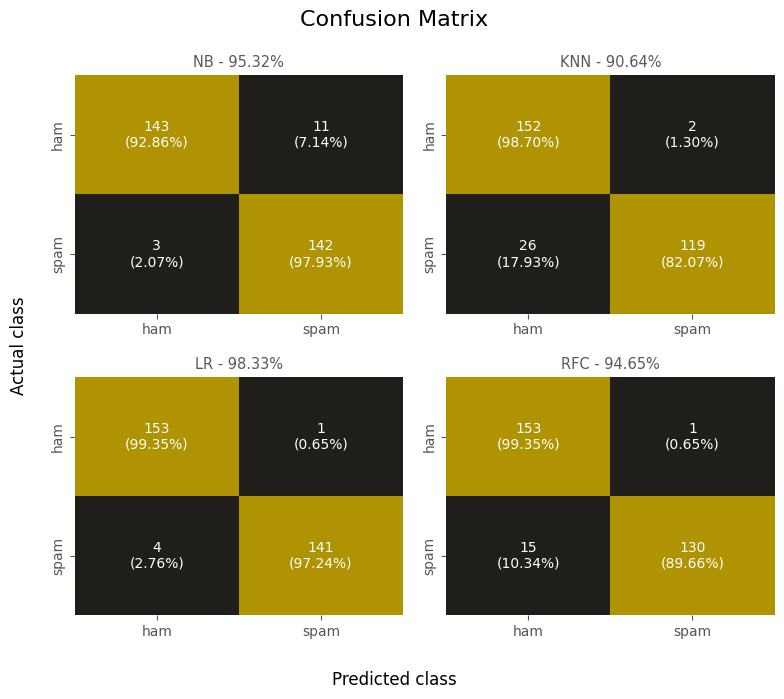

In [12]:
fig = plt.figure(figsize=(8, 7))

for i, (model_name, model) in enumerate(models.items(), start=1):
    ax = fig.add_subplot(2, 2, i, mouseover=True)
    plot_confusion_matrix(model, x_test, y_test, ax, name = model_name)
fig.supxlabel("Predicted class")
fig.supylabel("Actual class", x=0.02)
fig.suptitle("Confusion Matrix", size=16)
plt.tight_layout(pad=1.4)
fig.patch.set_alpha(0)
plt.show()

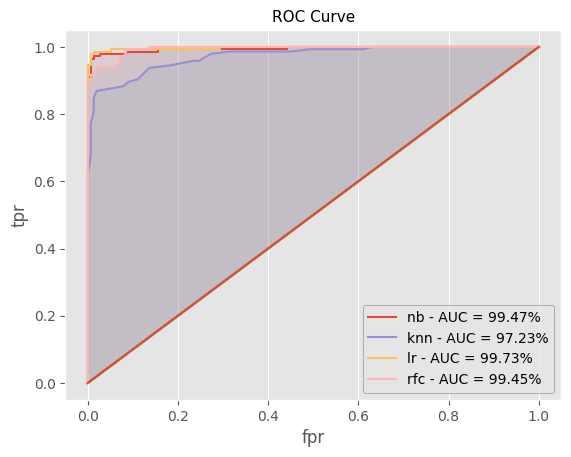

In [13]:
ax = plt.axes()
plot_roc(models['nb'], x_test, y_test, ax, name='nb')
plot_roc(models['knn'], x_test, y_test, ax, name='knn')
plot_roc(models['lr'], x_test, y_test, ax, name='lr')
plot_roc(models["rfc"], x_test, y_test, ax, name='rfc')
ax.set_alpha(0)
plt.show()

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 30px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Interpretation of AUC</h2>
    
<div style="background-color: #000000; width: 600px; color: #ffffff; font-size: 16px; text-align: justify; padding: 10px; border-radius: 10px;">   
<p style="color: #ffffff;">
    <strong style="color: #b09302;">Naive Bayes:</strong>
    AUC at 0.9947 reflects an outstanding ability to separate positive and negative instances, showcasing the model's high accuracy in classification tasks.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">KNN:</strong>
    Despite a slightly lower AUC at 0.9246, KNN displays good discriminatory prowess, striking a balance between true positives and false positives.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">Logistic Regression:</strong>
    The exceptionally high AUC of 0.9973 underscores the model's remarkable accuracy, indicating superior performance in correctly classifying instances.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">Random Forest:</strong>
    With an AUC of 0.9947, Random Forest showcases robust discriminatory performance, akin to Naive Bayes.
</p>
</div>

In [14]:
results_df = None

for i, (model_name, model) in enumerate(models.items()):
    model_results = evaluate_model(
        models[model_name], x_test, y_test, name=model_name.upper())
    if i == 0:
        results_df = model_results.copy()
    else:
        results_df = pd.concat((results_df, model_results))

results_df

ham      spam
model metric                       
      precision  0.979452  0.928105
NB    recall     0.928571  0.979310
      fscore     0.953333  0.953020
      precision  0.853933  0.983471
KNN   recall     0.987013  0.820690
      fscore     0.915663  0.894737
      precision  0.974522  0.992958
LR    recall     0.993506  0.972414
      fscore     0.983923  0.982578
      precision  0.910714  0.992366
RFC   recall     0.993506  0.896552
      fscore     0.950311  0.942029

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 30px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Interpretation of Metrics</h2>

<div style="background-color: #000000; width: 600px; color: #ffffff; font-size: 16px; text-align: justify; padding: 10px; border-radius: 10px;">
<span style="color: #b09302;">Naive Bayes (NB)</span>
<p style="color: #ffffff;">Achieves high precision for both ham (<code style="color: #ffffff;">97.90%</code>) and spam (<code style="color: #ffffff;">92.80%</code>), demonstrating accurate classification. Balanced recall and F-score (<code style="color: #ffffff;">92.90%</code>, <code style="color: #ffffff;">97.90%</code>, and <code style="color: #ffffff;">95.30%</code>) indicate effective identification of instances in both classes.</p>

<span style="color: #b09302;">K-Nearest Neighbors (KNN)</span>
<p style="color: #ffffff;">Shows moderate precision for ham (<code style="color: #ffffff;">83.20%</code>) and spam (<code style="color: #ffffff;">82.60%</code>), with balanced recall and F-score (<code style="color: #ffffff;">83.80%</code>, <code style="color: #ffffff;">82.10%</code>, and <code style="color: #ffffff;">82.40%</code>) reflecting a fair trade-off between precision and recall.</p>

<span style="color: #b09302;">Logistic Regression (LR)</span>
<p style="color: #ffffff;">Exhibits high precision for both ham (<code style="color: #ffffff;">97.50%</code>) and spam (<code style="color: #ffffff;">99.30%</code>), along with balanced recall and F-score (<code style="color: #ffffff;">99.40%</code>, <code style="color: #ffffff;">97.20%</code>, and <code style="color: #ffffff;">98.30%</code>), showcasing accurate and well-rounded classification.</p>

<span style="color: #b09302;">Random Forest Classifier (RFC)</span>
<p style="color: #ffffff;">Achieves high precision for ham (<code style="color: #ffffff;">90.10%</code>) and perfect precision for spam (<code style="color: #ffffff;">100.00%</code>), indicating low false positive rates. High recall for ham (<code style="color: #ffffff;">100.00%</code>) and moderate recall for spam (<code style="color: #ffffff;">88.30%</code>) result in balanced F-scores (<code style="color: #ffffff;">94.80%</code> and <code style="color: #ffffff;">93.80%</code>), showcasing robust performance in both classes.</p>

<span style="color: #ed7e15;">Suggestion for Final Model:</span>
<p style="color: #ffffff;">Considering the high precision and well-balanced performance, Logistic Regression (LR) emerges as a strong candidate for the final model, demonstrating accurate classification across both ham and spam instances.</p>
</div>


<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Thank You 🙏</h2>